In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import statistics
import nltk
import re
from scipy import stats
from venn import venn

import matplotlib.pyplot as plt
import squarify    
%matplotlib inline


In [4]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.regexp import RegexpStemmer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [5]:
pd.set_option('max_colwidth', 400)

In [6]:
def and_split(ingredient_list):
    """
    Inputs: List of ingredients (with possible "and" or "&")
    Output: List with ingredient list updated to remove "and" or "&" and list as separate items
    
    example: and_split(['turkey','green pepper','salt & freshly ground black pepper'])
            ['turkey', 'green pepper', 'salt', 'freshly ground black pepper']
    """
    return list(np.concatenate([re.split(' and | & ', ingredient) \
                                for ingredient in ingredient_list]).flat)

In [7]:
def make_singular(ingredient_list):
    """
    Inputs: List of ingredients 
    Output: List with ingredient list updated to make everything singular
    
    example:make_singular(["carrots", "eggs","milk"])
            returns ['carrot', 'egg', 'milk']
    """
    #edge case for couscous needs to be checked
    #stemmer = SnowballStemmer("english")
    stemmer = RegexpStemmer('s$|ies$') 
    return [stemmer.stem(word) for word in ingredient_list]

In [8]:
def remove_adj(ingredient_list):
    """
    Inputs: List of ingredients 
    Output: List with ingredient list updated to remove extra adjectives:
            ['fresh', 'ground', 'dried', 'all-purpose']
    example:remove_adj(['fresh ground pepper', 'fresh parsley', 'dried parsley','all-purpose flour'])
            returns ['pepper', 'parsley', 'parsley', 'flour']    
    """
    
    adj_list =  "|".join(['fresh','chopped','canned','baby' 'raw','frozen','whole',\
                          'ground','granulated', 'dried', 'all-purpose','granulated',\
                          'unsalted','salted', 'extra virgin', 'ripe'])
    return [re.sub(adj_list,'', ingredient).strip() for ingredient in ingredient_list]    

In [9]:
def check_subsitutions(sub_list, ingredient):
    new_ingredient = ingredient
    for word in sub_list:
        check = re.search(word, ingredient, re.IGNORECASE)
        new_ingredient = check.group(1) if check else new_ingredient
    return new_ingredient

def substitutions(ingredient_list):
    """
    Inputs: List of ingredients 
    Output: List with ingredient with common subsitituions 
    example: substitutions(['garlic cloves', 'herb and salt spice mix',  'low fat firm tofu', 'whole milk' ])
            returns ['garlic', 'spice', 'tofu', 'milk']    
    """
    sub_list = ['(garlic)', '(flour)','(yogurt)','(spice)', '(oil)','(tofu)', '(milk)', '(vinegar)',\
                '(butter)', '(rice)', '(cheese)', '(juice)', '(syrup)', '(soup)','(tortilla)', '(yam)']
    return [check_subsitutions(sub_list, ingredient) for ingredient in ingredient_list]
    #return [ingredient.extract(pat = r'("garlic")') for ingredient in ingredient_list]

In [10]:
recipes = pd.read_csv('data/large_data/RAW_recipes.csv')

In [11]:
recipes['tags'] = recipes['tags'].apply(literal_eval)

In [12]:
tag_dist = recipes['tags'].explode().value_counts()
tag_list = recipes['tags'].explode().unique()

In [13]:
recipes['mod_ingredients'] = recipes['ingredients'].apply(literal_eval).apply(and_split).apply(make_singular).apply(substitutions).apply(remove_adj)

In [14]:
full_ingredient_list = recipes['mod_ingredients'].explode()
ingredient_freq = full_ingredient_list.value_counts()

In [15]:
ingredient_freq = ingredient_freq.loc[ingredient_freq > 100]

In [16]:
ingredient_freq  = ingredient_freq/sum(ingredient_freq)

In [17]:
ingredient_freq.loc[np.abs(stats.zscore(ingredient_freq)) > 4]
#ingredient_freq.quantile(.50)

salt      0.053631
oil       0.042789
butter    0.038916
cheese    0.037887
garlic    0.035839
flour     0.028962
egg       0.025403
sugar     0.025266
onion     0.024572
juice     0.022410
pepper    0.022264
milk      0.021602
water     0.017375
Name: mod_ingredients, dtype: float64

In [18]:
ingredient_freq.loc['peanut']

0.0006646137927260607

In [19]:
ingredient_freq.filter(like="tomato", axis = 0)

tomatoe                           0.007197
tomato sauce                      0.002229
tomato paste                      0.002157
diced tomatoe                     0.001722
cherry tomatoe                    0.000821
plum tomatoe                      0.000601
crushed tomatoe                   0.000570
tomato                            0.000475
stewed tomatoe                    0.000441
roma tomatoe                      0.000412
tomato puree                      0.000353
grape tomatoe                     0.000288
sun- tomato                       0.000270
sun- tomatoe                      0.000230
rotel tomatoe                     0.000206
diced tomato                      0.000188
plum tomato                       0.000135
roma tomato                       0.000129
tomato ketchup                    0.000093
diced tomatoes with green chil    0.000082
italian tomatoe                   0.000067
italian-style diced tomatoe       0.000060
italian plum tomatoe              0.000060
green tomat

In [20]:
full_ingredient_list[-100:]

231627        kosher salt
231627             butter
231627              water
231627              bacon
231627        white onion
               ...       
231636                egg
231636              flour
231636    cream of tartar
231636        baking soda
231636    vanilla extract
Name: mod_ingredients, Length: 100, dtype: object

In [21]:
recipes["veg"] = [("vegan" in tag_list) or ("vegetarian" in tag_list) for tag_list in recipes["tags"]]

In [22]:
veg_recipes = recipes[recipes["veg"]].copy()

In [23]:
interactions = pd.read_csv('data/large_data/RAW_interactions.csv')

In [24]:
veg_recipes['ratings'] = [list(interactions[interactions['recipe_id'] == rec_id]['rating'])  for rec_id in veg_recipes['id'] ]

In [25]:
veg_recipes['avg_rating'] = veg_recipes['ratings'].map(statistics.mean)

In [26]:
veg_recipes['n_ratings'] = veg_recipes['ratings'].map(len)

In [27]:
veg_recipes[veg_recipes['n_ratings'] > 10].describe()

,id,minutes,contributor_id,n_steps,n_ingredients,avg_rating,n_ratings
count,3128.000000,3128.000000,3.128000e+03,3128.000000,3128.000000,3128.000000,3128.000000
mean,142169.992967,79.190217,1.624612e+05,8.831841,8.501918,4.460244,28.839834
std,110971.657708,500.792949,2.163368e+05,5.544758,3.650987,0.411377,43.603142
min,62.000000,0.000000,2.700000e+01,1.000000,2.000000,1.764706,11.000000
25%,50842.750000,17.000000,3.744900e+04,5.000000,6.000000,4.266667,13.000000
50%,117433.500000,31.000000,7.132400e+04,8.000000,8.000000,4.538462,17.000000
75%,204854.750000,58.500000,2.097470e+05,11.000000,11.000000,4.750000,28.000000
max,512584.000000,20190.000000,2.222923e+06,82.000000,25.000000,5.000000,1220.000000


In [28]:
veg_recipes['mod_ingredients'] = veg_recipes['ingredients'].apply(literal_eval).apply(and_split)

In [29]:
veg_recipes[['mod_ingredients']]
#veg_recipes[['ingredients']]

,mod_ingredients
0,"[winter squash, mexican seasoning, mixed spice, honey, butter, olive oil, salt]"
4,"[tomato juice, apple cider vinegar, sugar, salt, pepper, clove oil, cinnamon oil, dry mustard]"
6,"[fennel seeds, green olives, ripe olives, garlic, peppercorn, orange rind, orange juice, red chile, extra virgin olive oil]"
16,"[egg roll wrap, whole green chilies, cheese, cornstarch, oil]"
19,"[canola oil, onion, garlic, cauliflower, potatoes, vegetable bouillon cubes, water, salt free herb, spice seasoning mix, ground coriander, great northern bean, salt, pepper, broccoli floret, escarole, green peas, red bell pepper, fresh herb]"
...,...
231610,"[white bread flour, instant yeast, sugar, salt, water]"
231613,"[sorrel, butter, sugar, raisins]"
231620,"[milk, butter, dry yeast, water, salt, sugar, flour]"
231625,"[butter, onions, flour, salt, vinegar]"


In [30]:
#search_phrase = input()

In [31]:
search_phrase = "butternut squash soup"
search_words = search_phrase.split(" ")
search_words = "|".join("^{}$".format(word) for word in search_words)

In [75]:
recipe_list = veg_recipes.loc[veg_recipes['name'].str.contains(search_phrase, case=False)].copy()

In [76]:
recipe_list.describe()

,id,minutes,contributor_id,n_steps,n_ingredients,avg_rating,n_ratings
count,23.000000,23.000000,2.300000e+01,23.000000,23.000000,23.000000,23.000000
mean,238846.217391,62.913043,4.463659e+05,12.260870,11.217391,4.304743,4.260870
std,142403.200255,38.257397,5.458591e+05,6.091853,3.789417,0.821696,6.565872
min,11636.000000,9.000000,3.288000e+03,5.000000,6.000000,2.333333,1.000000
25%,157662.000000,35.000000,8.702850e+04,7.500000,7.500000,4.000000,1.000000
50%,226765.000000,48.000000,2.398970e+05,12.000000,11.000000,4.714286,2.000000
75%,313188.500000,90.000000,5.575435e+05,15.000000,13.500000,5.000000,4.000000
max,490345.000000,170.000000,2.462143e+06,27.000000,21.000000,5.000000,31.000000


In [77]:
common_ingredients = recipe_list['mod_ingredients'].explode().value_counts()

In [78]:
common_ingredients.filter(like = "pepper", axis = 0)

pepper                         7
red bell pepper                2
black pepper                   2
red pepper flakes              1
freshly ground black pepper    1
chili pepper                   1
scotch bonnet pepper           1
cayenne pepper                 1
dry crushed red pepper         1
ground red pepper              1
white pepper                   1
ground pepper                  1
yellow bell pepper             1
Name: mod_ingredients, dtype: int64

In [ ]:
veg_recipes['ingredients']

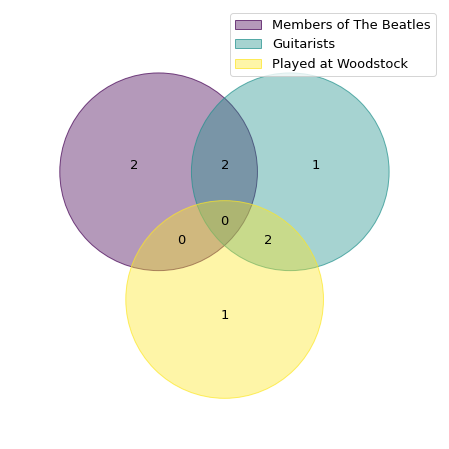

In [13]:
musicians = {
    "Members of The Beatles": {"Paul McCartney", "John Lennon", "George Harrison", "Ringo Starr"},
    "Guitarists": {"John Lennon", "George Harrison", "Jimi Hendrix", "Eric Clapton", "Carlos Santana"},
    "Played at Woodstock": {"Jimi Hendrix", "Carlos Santana", "Keith Moon"}
}
venn(musicians)

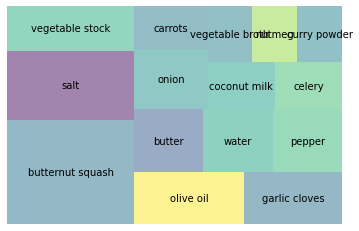

In [46]:
# Create a data frame with fake data
#df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })

# plot it
#squarify.plot(sizes=df['nb_people'], label=df['group'], alpha=.8 )
squarify.plot(sizes=common_ingredients[:15], label=common_ingredients.index[:15], alpha=.5 )
plt.axis('off')
plt.show()

In [79]:
recipe_list['ingredient_score'] = recipe_list['mod_ingredients'].apply(calc_ingredient_ratings)

In [71]:
def calc_ingredient_ratings(ingredient_list, ingredient_freq= ingredient_freq):
    #print(ingredient_list) 
    rating = 0
    for ingredient in ingredient_list:
        try:
            freq = ingredient_freq.loc[ingredient]
        except:
            freq = 0
        rating += freq
    return rating
    
calc_ingredient_ratings(['salt','butter','pepper','shoe'])

0.11481054029718583

In [80]:
recipe_list.describe()

,id,minutes,contributor_id,n_steps,n_ingredients,avg_rating,n_ratings,ingredient_score
count,23.000000,23.000000,2.300000e+01,23.000000,23.000000,23.000000,23.000000,23.000000
mean,238846.217391,62.913043,4.463659e+05,12.260870,11.217391,4.304743,4.260870,0.081922
std,142403.200255,38.257397,5.458591e+05,6.091853,3.789417,0.821696,6.565872,0.037237
min,11636.000000,9.000000,3.288000e+03,5.000000,6.000000,2.333333,1.000000,0.004880
25%,157662.000000,35.000000,8.702850e+04,7.500000,7.500000,4.000000,1.000000,0.060182
50%,226765.000000,48.000000,2.398970e+05,12.000000,11.000000,4.714286,2.000000,0.078203
75%,313188.500000,90.000000,5.575435e+05,15.000000,13.500000,5.000000,4.000000,0.095717
max,490345.000000,170.000000,2.462143e+06,27.000000,21.000000,5.000000,31.000000,0.149002


In [81]:
recipe_list['overall_score'] = recipe_list['avg_rating'] + recipe_list['ingredient_score']*100 - recipe_list['n_steps']/10 - recipe_list['n_ingredients']/10

In [83]:
recipe_list.sort_values(by = 'overall_score', ascending=False)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,mod_ingredients,veg,ratings,avg_rating,n_ratings,ingredient_score,overall_score
210378,thai butternut squash soup,286216,50,211492,2008-02-12,"[lactose, 60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, bisques-cream-soups, soups-stews, fruit, vegetables, asian, thai, european, dinner-party, vegan, vegetarian, english, dietary, gluten-free, free-of-something, tropical-fruit, mango, carrots, squash]","[288.9, 25.0, 44.0, 2.0, 9.0, 53.0, 12.0]",8,"['peel the squash , remove seeds and cut into large cubes together with the carrot', 'heat the oil and cook the onione with garlic and ginger until soft , but not browned', 'add the squash , carrots and lemongrass , just cover with vegetable stock , bring to boil and cook on low power until squash is tender', 'add the mango and chilli sometime during the cooking', 'add the coconut milk and cur...","this is my first recipe in zaar and a variation on a recipe from lisa connely (recipe #38904). i liked the original, but decided to tweak it to improve the thainess factor and make it both sweeter and hotter at the same time. the result was oh so good, now this is going to be the butternut squash soup for me for ever!\r\n\r\nthe carrots are there mostly for the added colour and mango for the s...","['butternut squash', 'onion', 'garlic cloves', 'fresh ginger', 'carrots', 'mango', 'oil', 'vegetable stock', 'coconut milk', 'curry powder', 'lemongrass', 'chili pepper', 'salt', 'sugar']",14,"[butternut squash, onion, garlic cloves, fresh ginger, carrots, mango, oil, vegetable stock, coconut milk, curry powder, lemongrass, chili pepper, salt, sugar]",True,"[5, 5]",5.000000,2,0.149002,17.700184
10930,autumn gold butternut squash soup,11636,35,10404,2001-09-13,"[60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, low-protein, healthy, soups-stews, vegetables, american, fall, low-fat, vegan, vegetarian, stove-top, dietary, low-sodium, low-cholesterol, seasonal, low-saturated-fat, low-calorie, low-carb, healthy-2, low-in-something, equipment]","[190.4, 3.0, 73.0, 11.0, 7.0, 2.0, 14.0]",5,"['cook the squash-i boil it for this recipe and use the broth in place of the water called for', 'saute the chopped onion in the oil with the spices and bay until onion is translucent', 'add the carrot and celery and the squash water', 'cover and simmer until carots are tender', 'remove bay leaves puree the veg and squash , whisk in juices return to a simmer , taste and add salt and pepper']","another great recipe from ""sundays at moosewood restaurant""","['butternut squash', 'onion', 'vegetable oil', 'nutmeg', 'cinnamon', 'thyme', 'bay leaves', 'carrot', 'celery', 'water', 'tomato soup', 'apple juice', 'orange juice', 'salt and pepper']",14,"[butternut squash, onion, vegetable oil, nutmeg, cinnamon, thyme, bay leaves, carrot, celery, water, tomato soup, apple juice, orange juice, salt, pepper]",True,[4],4.000000,1,0.148380,16.937951
32525,butternut squash soup with vegetable stock,226765,90,496329,2007-05-08,"[time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, main-dish, soups-stews, vegetables, american, vegetarian, winter, dietary, seasonal, comfort-food, inexpensive, squash, taste-mood, presentation, served-hot, 4-hours-or-less]","[327.6, 24.0, 43.0, 25.0, 9.0, 16.0, 16.0]",14,"['preheat the oven to 400f', 'brush the bottom of a baking pan with olive oil and set aside', 'cut the squash through the stem ends into halves , prick the skin in several places , and scoop out the seeds', 'brush the cut surfaces with about a tablespoon of the olive oil', 'put the garlic inside the squash cavities and place halves in the pan cut side down', 'add the onions to the pan and brus...",adapted from moosewood restaurant recipe,"['olive oil', 'butternut squash', 'garlic cloves', 'onions', 'w

In [ ]:
# https://www.food.com/recipe/